## Code to verify ERA5 and WRF simulations against Copernicus Scatterometer Observations:

#### Loading Python modules:

In [1]:
import numpy as np
import numpy 
from netCDF4 import Dataset
import csv
import glob 
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import os
from mpl_toolkits.basemap import Basemap
from scipy.ndimage.filters import gaussian_filter
from wrf import ALL_TIMES
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
cartopy_ylim, latlon_coords)
from wrf import getvar, interplevel, interpz3d
import matplotlib.colors as mcolors
import pygrib
import cfgrib
from datetime import datetime
from datetime import datetime, timedelta
from scipy.interpolate import griddata
import pickle

/perm/bidc/conda/envs/Emmanouil_Project/lib/python3.8/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.26.0
  warnings.warn(


#### Enter to the work directory where the figures will be stored:

In [2]:
cd /hpcperm/bidc/Project_Spgrflao/Paper/Plots/Verifications_Copernicus_Scatterometers

/lus/h2resw01/hpcperm/bidc/Project_Spgrflao/Paper/Plots/Verifications_Copernicus_Scatterometers


#### Obtaining variables of interest from ERA5 and WRF simulations:

In [19]:
# Loading dataset with pickle:
cyc_num              = 1
#folder_era5_wrf_path = '../ERA5_Inter_WRF_Cyclones/'
folder_era5_wrf_path = '/scratch/bidc/DCC/ERA5_Inter_WRF_Cyclones/'
file_name            = folder_era5_wrf_path+'wspeed_ERA5_Interpolation2WRF_Cyc_{:04d}_binary'.format(cyc_num)
binary_file          = open(file_name,"rb")
dataset_models       = pickle.load(binary_file)
dataset_models.keys()

dict_keys(['ws_interp_era5', 'ws_interp_wrf_d01', 'wind_speed_wrf_d02', 'lat', 'lon'])

#### Obtaining variables of interest Copernicus observations:

In [4]:
# Loading dataset with pickle:
folder_obs_path = '../Copernicus_Obs/'
file_name       = folder_obs_path+'wspeed_Copernicus_Interpolation2WRF_Cyc_{:04d}_binary'.format(cyc_num)
binary_file     = open(file_name,"rb")
dataset_obs     = pickle.load(binary_file)
dataset_obs.keys()

dict_keys(['ws_interp_copernicus', 'wind_speed_wrf', 'lat_wrf', 'lon_wrf'])

In [22]:
lat         = dataset_obs['lat_wrf'][0,:,:].values
lon         = dataset_obs['lon_wrf'][0,:,:].values
ws_obs      = dataset_obs['ws_interp_copernicus']
ws_wrf_d01  = dataset_models['ws_interp_wrf_d01']
ws_wrf_d02  = dataset_models['wind_speed_wrf_d02']
ws_era5     = dataset_models['ws_interp_era5']

In [23]:
ws_wrf_d01

array([[[14.35133954, 14.3382589 , 14.32392296, ...,  3.77478336,
          3.76818415,  3.78320045],
        [14.45820127, 14.44374657, 14.42787943, ...,  3.94221048,
          3.91620612,  3.91520874],
        [14.55644981, 14.54058707, 14.52183968, ...,  4.11719265,
          4.07459772,  4.05997616],
        ...,
        [ 8.54538389,  8.66516879,  8.7940733 , ...,  9.43986674,
          9.54997045,  9.62300812],
        [ 8.63946804,  8.77218437,  8.91195431, ...,  9.53190086,
          9.62435722,  9.69147677],
        [ 8.75802768,  8.90298493,  9.0559375 , ...,  9.62181204,
          9.70168342,  9.76330608]],

       [[ 9.64367541,  9.64479368,  9.60770625, ...,  3.83506212,
          3.83169071,  3.83667639],
        [ 9.66720922,  9.65956306,  9.62017676, ...,  4.00599285,
          3.98919511,  3.98465233],
        [ 9.71043432,  9.69824266,  9.66374378, ...,  4.1656463 ,
          4.14007408,  4.12766133],
        ...,
        [ 9.51922485,  9.75243681,  9.97690582, ...,  

In [27]:
ws_wrf_d02

array([[[14.35339832, 14.33926296, 14.32365608, ...,  3.77580452,
          3.76882529,  3.78367686],
        [14.45899773, 14.44374657, 14.427145  , ...,  3.94168878,
          3.91620612,  3.91464233],
        [14.55638123, 14.53985977, 14.52208138, ...,  4.11793423,
          4.07597494,  4.05937672],
        ...,
        [ 8.54396915,  8.66498756,  8.793293  , ...,  9.44447517,
          9.54945946,  9.62677097],
        [ 8.63845062,  8.77218437,  8.91276836, ...,  9.5324564 ,
          9.62435722,  9.69458008],
        [ 8.75487614,  8.90205574,  9.05505848, ...,  9.62326145,
          9.70248604,  9.76531506]],

       [[ 9.66070271,  9.65273666,  9.62323856, ...,  3.98188567,
          3.96687675,  3.83973026],
        [ 9.71485901,  9.71812534,  9.65454197, ...,  4.18194485,
          4.03925467,  3.86783433],
        [ 9.73870754,  9.74206448,  9.68593407, ...,  4.21149158,
          4.04474211,  3.99305582],
        ...,
        [ 9.52258873,  9.76585865,  9.99203968, ...,  

#### Creating Basemap:

In [24]:
proj, moad_cen_lat, cen_lat, cen_lon, truelat1, truelat2, standlon = "lcc", 38, 38, 12, 34, 36, 12
#x_dim, y_dim = 650, 350
x_dim, y_dim = 350, 250
dx, dy = 9000, 9000
width_meters, height_meters = dx * (x_dim - 1), dy * (y_dim - 1) 
    
m_d01 = Basemap(resolution="h",projection=proj,rsphere=6370000.,width=width_meters,height=height_meters,lat_0=cen_lat,lon_0=cen_lon,lat_1=truelat1,lat_2=truelat2,area_thresh=100.) 

#### Plotting Figure:

Text(0.5, 1.0, 'Copernicus Obs Interp Wind Speed at 10 m')

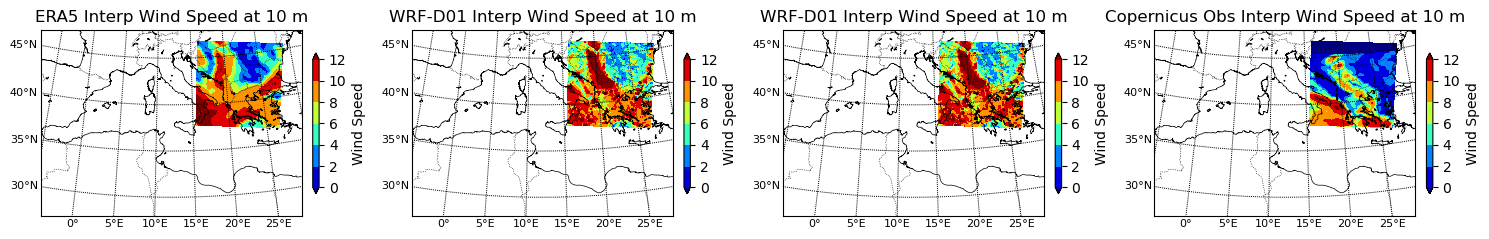

In [25]:
# Selecting time step:
tt = 60

# Plotting map:
from matplotlib import cm
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(141)
parallels = np.arange(-90,90,5)
meridians = np.arange(0,360,5)
m_d01.drawcoastlines(color="black",linewidth=0.5)
m_d01.drawstates(linestyle="dotted")
m_d01.drawcountries(linestyle="dotted")
m_d01.drawparallels(parallels,labels=[1,0,0,0],fontsize=8,linewidth=.7)
m_d01.drawmeridians(meridians,labels=[0,0,0,1],fontsize=8,linewidth=.7)
x, y = m_d01(lon,lat) # compute map proj coordinates of the grid points
clevs=np.arange(0,14,2)
cs1 = m_d01.contourf(x,y,ws_era5[tt,:,:],clevs,cmap=plt.cm.jet,extend='both')
plt.colorbar(cs1, label= 'Wind Speed',fraction=0.023,pad=0.04)
fig.tight_layout()
plt.title('ERA5 Interp Wind Speed at 10 m')
#
ax = fig.add_subplot(142)
parallels = np.arange(-90,90,5)
meridians = np.arange(0,360,5)
m_d01.drawcoastlines(color="black",linewidth=0.5)
m_d01.drawstates(linestyle="dotted")
m_d01.drawcountries(linestyle="dotted")
m_d01.drawparallels(parallels,labels=[1,0,0,0],fontsize=8,linewidth=.7)
m_d01.drawmeridians(meridians,labels=[0,0,0,1],fontsize=8,linewidth=.7)
x, y = m_d01(lon,lat) # compute map proj coordinates of the grid points
#clevs=np.arange(0,14,2)
cs1 = m_d01.contourf(x,y,ws_wrf_d01[tt,:,:],clevs,cmap=plt.cm.jet,extend='both')
plt.colorbar(cs1, label= 'Wind Speed',fraction=0.023,pad=0.04)
fig.tight_layout()
plt.title('WRF-D01 Interp Wind Speed at 10 m')
#
ax = fig.add_subplot(143)
parallels = np.arange(-90,90,5)
meridians = np.arange(0,360,5)
m_d01.drawcoastlines(color="black",linewidth=0.5)
m_d01.drawstates(linestyle="dotted")
m_d01.drawcountries(linestyle="dotted")
m_d01.drawparallels(parallels,labels=[1,0,0,0],fontsize=8,linewidth=.7)
m_d01.drawmeridians(meridians,labels=[0,0,0,1],fontsize=8,linewidth=.7)
x, y = m_d01(lon,lat) # compute map proj coordinates of the grid points
#clevs=np.arange(0,14,2)
cs1 = m_d01.contourf(x,y,ws_wrf_d02[tt,:,:],clevs,cmap=plt.cm.jet,extend='both')
plt.colorbar(cs1, label= 'Wind Speed',fraction=0.023,pad=0.04)
fig.tight_layout()
plt.title('WRF-D01 Interp Wind Speed at 10 m')
#
ax = fig.add_subplot(144)
parallels = np.arange(-90,90,5)
meridians = np.arange(0,360,5)
m_d01.drawcoastlines(color="black",linewidth=0.5)
m_d01.drawstates(linestyle="dotted")
m_d01.drawcountries(linestyle="dotted")
m_d01.drawparallels(parallels,labels=[1,0,0,0],fontsize=8,linewidth=.7)
m_d01.drawmeridians(meridians,labels=[0,0,0,1],fontsize=8,linewidth=.7)
x, y = m_d01(lon,lat) # compute map proj coordinates of the grid points
#clevs=np.arange(0,14,2)
#cs1 = m_d01.contourf(x,y,ws_obs[tt,:,:],cmap=plt.cm.jet,extend='both')
ws_obs_nnans = np.nan_to_num(ws_obs[tt,:,:], nan=0)
cs1 = m_d01.contourf(x,y,ws_obs_nnans,clevs,cmap=plt.cm.jet,extend='both')
plt.colorbar(cs1, label= 'Wind Speed',fraction=0.023,pad=0.04)
fig.tight_layout()
plt.title('Copernicus Obs Interp Wind Speed at 10 m')


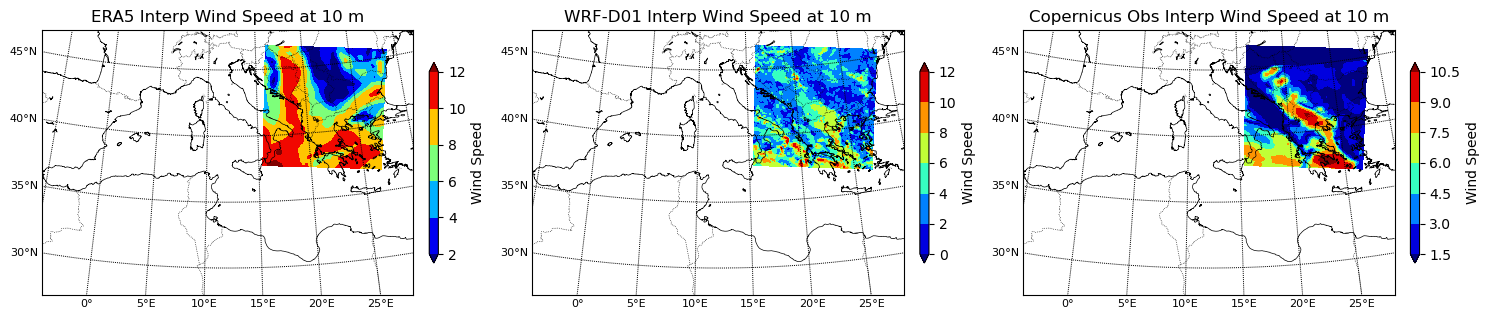

In [26]:
# Selecting time step:
tt = 65

# Plotting map:
from matplotlib import cm
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(131)
parallels = np.arange(-90,90,5)
meridians = np.arange(0,360,5)
m_d01.drawcoastlines(color="black",linewidth=0.5)
m_d01.drawstates(linestyle="dotted")
m_d01.drawcountries(linestyle="dotted")
m_d01.drawparallels(parallels,labels=[1,0,0,0],fontsize=8,linewidth=.7)
m_d01.drawmeridians(meridians,labels=[0,0,0,1],fontsize=8,linewidth=.7)
x, y = m_d01(lon,lat) # compute map proj coordinates of the grid points
clevs=np.arange(0,20,2)
cs1 = m_d01.contourf(x,y,ws_era5[tt,:,:],cmap=plt.cm.jet,extend='both')
plt.colorbar(cs1, label= 'Wind Speed',fraction=0.023,pad=0.04)
fig.tight_layout()
plt.title('ERA5 Interp Wind Speed at 10 m')
#
ax = fig.add_subplot(132)
parallels = np.arange(-90,90,5)
meridians = np.arange(0,360,5)
m_d01.drawcoastlines(color="black",linewidth=0.5)
m_d01.drawstates(linestyle="dotted")
m_d01.drawcountries(linestyle="dotted")
m_d01.drawparallels(parallels,labels=[1,0,0,0],fontsize=8,linewidth=.7)
m_d01.drawmeridians(meridians,labels=[0,0,0,1],fontsize=8,linewidth=.7)
x, y = m_d01(lon,lat) # compute map proj coordinates of the grid points
clevs=np.arange(0,20,2)
cs1 = m_d01.contourf(x,y,ws_wrf[tt,:,:],cmap=plt.cm.jet,extend='both')
plt.colorbar(cs1, label= 'Wind Speed',fraction=0.023,pad=0.04)
fig.tight_layout()
plt.title('WRF-D01 Interp Wind Speed at 10 m')
#
ax = fig.add_subplot(133)
parallels = np.arange(-90,90,5)
meridians = np.arange(0,360,5)
m_d01.drawcoastlines(color="black",linewidth=0.5)
m_d01.drawstates(linestyle="dotted")
m_d01.drawcountries(linestyle="dotted")
m_d01.drawparallels(parallels,labels=[1,0,0,0],fontsize=8,linewidth=.7)
m_d01.drawmeridians(meridians,labels=[0,0,0,1],fontsize=8,linewidth=.7)
x, y = m_d01(lon,lat) # compute map proj coordinates of the grid points
clevs=np.arange(0,20,2)
#cs1 = m_d01.contourf(x,y,ws_obs[tt,:,:],cmap=plt.cm.jet,extend='both')
ws_obs_nnans = np.nan_to_num(ws_obs[tt,:,:], nan=0)
cs1 = m_d01.contourf(x,y,ws_obs_nnans,cmap=plt.cm.jet,extend='both')
plt.colorbar(cs1, label= 'Wind Speed',fraction=0.023,pad=0.04)
fig.tight_layout()
plt.title('Copernicus Obs Interp Wind Speed at 10 m')
fig.savefig('Verification_test.png',dpi=300)
